In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
from google.colab.patches import cv2_imshow
import re
from bs4 import BeautifulSoup #for reading xml file
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS  #for plotting wordcloud
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Exploratory Data Analysis**

## **Images**

In [3]:
image_folder = 'drive/My Drive/self2/newimage' #path to folder containing images
total_images = len(os.listdir(image_folder))
print('The number of images in data are: %i'%(total_images))

The number of images in data are: 38


1)



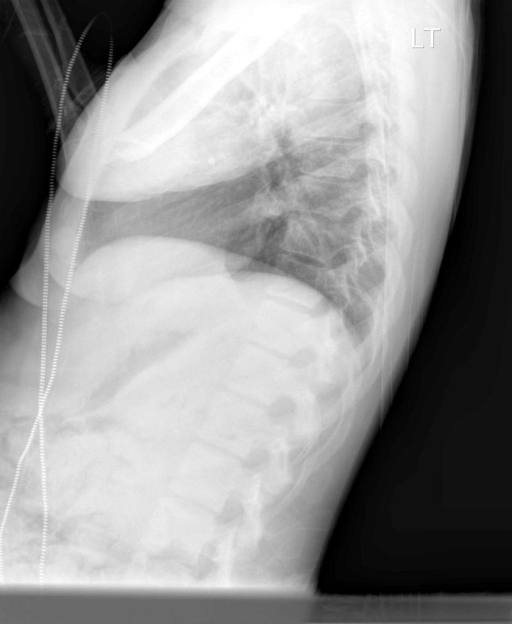

		 CXR3999_IM-2049-2001.png
2)



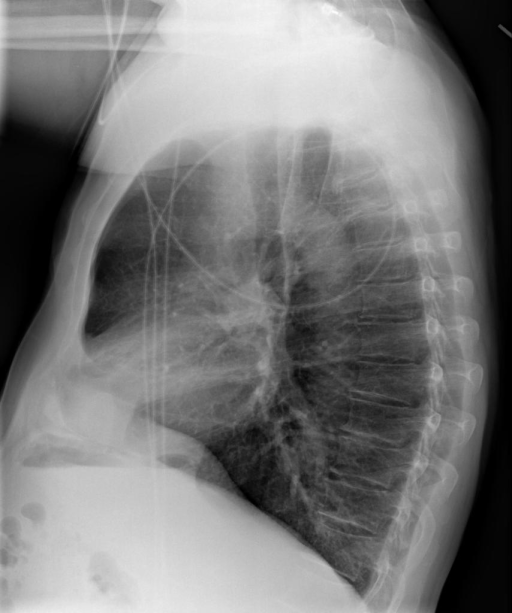

		 CXR3995_IM-2046-2001.png
3)



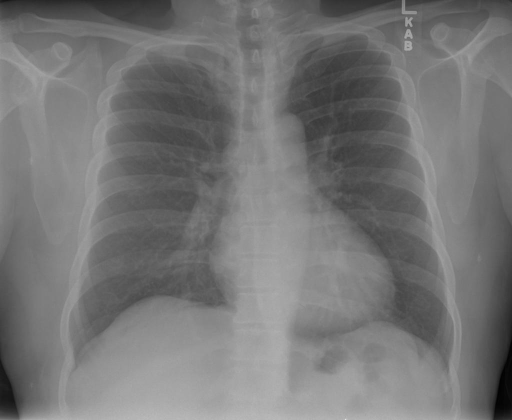

		 CXR3982_IM-2039-1001.png


In [4]:
#showing random 3 sample images
np.random.seed(420)
for i in range(3): #print 5 sample images
  k = np.random.choice(range(total_images))
  image_file = os.listdir(image_folder)[k]
  image = cv2.imread(os.path.join(image_folder,image_file)) #getting an image file
  print("%i)\n"%(i+1))
  cv2_imshow(image)
  print("\t\t",image_file) #the image file name

We can see 3 sample images of the dataset. These are chest X_rays which are taken in  front and side view.

In [5]:
reports_folder = "drive/My Drive/self2/newreport"
total_reports = len(os.listdir(reports_folder))
print('The number of reports in the data are: %i'%(total_reports))

The number of reports in the data are: 20


In [6]:
no_images = [] #stores the no. of images
for file in os.listdir(reports_folder):
  report_file = os.path.join(reports_folder,file)
  with open(report_file, 'r') as f:  #reading the xml data
    data = f.read()
  regex = r"parentImage id.*" #getting all the image names
  k  = re.findall(regex,data)
  temp = len(k)
  no_images.append(temp)

In [7]:
no_images = np.array(no_images)
print("The max no. of images found associated with a report: %i"%(no_images.max()))
print("The min no. of images found associated with a report: %i"%(no_images.min()))

The max no. of images found associated with a report: 3
The min no. of images found associated with a report: 0


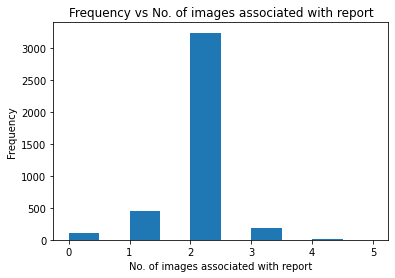

Image Value_counts

2    3234
1     449
3     182
0     104
4      15
5       1
dtype: int64


In [ ]:
plt.figure(figsize = (6,4))
ax = pd.Series(no_images).plot(kind='hist')
ax.set_xlabel('No. of images associated with report')
ax.set_title("Frequency vs No. of images associated with report")
plt.show()
print("Image Value_counts\n")
print(pd.Series(no_images).value_counts())

We can see that the maximum number of images associated with a report can be 5 while the minimum is 0. We will extract all the information part ie comparison, indication, findings and impression part of the report and the corresponding 2 images (we will take 2 images as input as 2 images are highest frequecy of being associated with a report) of the concerned report to a dataframe with xml report file name. For images more than 2, we will creat new datapoint with new image and same info.

In [8]:
# function for obtaining the different information part of the xml report file and preprocessing them and also adding the concernced image and report information to the dataframe
def decontracted(phrase): #https://stackoverflow.com/a/47091490
  """
  performs text decontraction of words like won't to will not
  """
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


def get_info(xml_data,info): #https://regex101.com/
  """
  extracts the information data from the xml file and does text preprocessing on them
  here info can be 1 value in this list ["COMPARISON","INDICATION","FINDINGS","IMPRESSION"]
  """
  regex = r"\""  +info +r"\".*" 
  k = re.findall(regex,xml_data)[0] #finding info part of the report
  #print(k)#"INDICATION">The patient is a XXXX-year-old male with kidney transplant evaluation.</AbstractText>
 # print('___________________')
  regex = r"\>.*\<"
  k = re.findall(regex,k)[0] #removing info string and /AbstractText>'
  #print(k)#>The patient is a XXXX-year-old male with kidney transplant evaluation.<
  #print('-------------')
  regex = r"\d." 
  k = re.sub(regex,"",k) #removing all values like "1." and "2." etc
 # print(k)#>The patient is a XXXX-year-old male with kidney transplant evaluation.<
  #print('*****************')
  #print('end')
  regex = r"X+"
  k = re.sub(regex,"",k) #removing words like XXXX

  regex = r" \."
  k = re.sub(regex,"",k) #removing singular fullstop ie " ."

  regex = r"[^.a-zA-Z]" 
  k = re.sub(regex," ",k) #removing all special characters except for full stop

  regex = r"\."
  k = re.sub(regex," .",k) #adding space before fullstop
  k = decontracted(k) #perform decontraction
  k = k.strip().lower() #strips the begining and end of the string of spaces and converts all into lowercase
  k = " ".join(k.split()) #removes unwanted spaces
  if k=="": #if the resulting sentence is an empty string return null value
    k = np.nan
  return k

def get_final(data):
  """
  given an xml data returns "COMPARISON","INDICATION","FINDINGS","IMPRESSION" part of the data
  """
  try: #assigning null values to the ones that don't have the concerned info
      comparison = get_info(data, "COMPARISON")
  except:
    comparison = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    indication = get_info(data, "INDICATION")
  except:
    indication = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    finding = get_info(data,"FINDINGS")
  except:
    finding = np.nan;

  try: #assigning null values to the ones that don't have the concerned info
    impression = get_info(data, "IMPRESSION")
  except:
    impression = np.nan;

  return comparison,indication,finding,impression

def get_df():
  """
  Given an xml data, it will extract the two image names and corresponding info text and returns a dataframe
  """
  im1 = [] #there are 2 images associated with a report
  im2 = []
  #stores info
  comparisons = []
  indications = []
  findings = []
  impressions = [] 
  report = [] #stores xml file name
  for file in tqdm(os.listdir(reports_folder)):
    report_file = os.path.join(reports_folder,file)
    with open(report_file, 'r') as f:  #reading the xml data
      data = f.read()
      
    regex = r"parentImage id.*" #getting all the image names here .* means matching any chracter and it's repetation
    k  = re.findall(regex,data)
   # print(k)
   # print('________________________')#['parentImage id="CXR3989_IM-2042-1001">', 'parentImage id="CXR3989_IM-2042-2001">'] k means
    if len(k)==2: 
      regex = r"\".*\"" #getting the name here it means  inside the " " whatever is present it will take regax variable
      image1 = re.findall(regex,k[0])[0]
      image2 = re.findall(regex,k[1])[0]
     # print(image1)##"CXR3989_IM-2042-1001"
    #  print('____________________________')
      image1 = re.sub(r"\"","",image1)
      image2 = re.sub(r"\"","",image2)
    #  print(image1)######CXR3989_IM-2042-1001
     # print('______________________________')
      image1 = image1.strip()+".png"
      image2 = image2.strip()+".png"
      im1.append(image1)
      im2.append(image2)

      comparison,indication,finding,impression = get_final(data)
      comparisons.append(comparison)
      indications.append(indication)
      findings.append(finding)
      impressions.append(impression)
      report.append(file) #xml file name

    
    elif len(k)<2:
      regex = r"\".*\"" #getting the name
      try: #if the exception is raised means no image file name was found
        image1 = re.findall(regex,k[0])[0]
        image1 = re.sub(r"\"","",image1) #removing "
        image2 = np.nan

        image1 = image1.strip()+".png"
      except:
        image1 = np.nan
        image2 = np.nan


      im1.append(image1)
      im2.append(image2)
      comparison,indication,finding,impression = get_final(data)
      comparisons.append(comparison)
      indications.append(indication)
      findings.append(finding)
      impressions.append(impression)
      report.append(file) #xml file name
    
    else: #if there are more than 2 images concerned with report
      comparison,indication,finding,impression = get_final(data)

      for i in range(len(k)-1):
        regex = r"\".*\"" #getting the name
        image1 = re.findall(regex,k[i])[0] #re.findall returns a list
        image2 = re.findall(regex,k[i+1])[0] 

        image1 = re.sub(r"\"","",image1) #removing "
        image2 = re.sub(r"\"","",image2) #removing "

        image1 = image1.strip()+".png"
        image2 = image2.strip()+".png"

        im1.append(image1)
        im2.append(image2)
        comparisons.append(comparison)
        indications.append(indication)
        findings.append(finding)
        impressions.append(impression)
        report.append(file) #xml file name
    
  df = pd.DataFrame({"image_1":im1,"image_2":im2,"comparison":comparisons,"indication":indications,"findings":findings,"impression":impressions,"xml file name":report})
  return df

In [9]:
%%time
df = get_df()

100%|██████████| 20/20 [00:00<00:00, 753.10it/s]

CPU times: user 19.2 ms, sys: 5.3 ms, total: 24.5 ms
Wall time: 46.8 ms


In [10]:
df.head()

,image_1,image_2,comparison,indication,findings,impression,xml file name
0,CXR3985_IM-2041-1001.png,CXR3985_IM-2041-2001.png,none .,the patient is a year old male with kidney tra...,no pneumothorax pleural effusion or airspace c...,no acute cardiopulmonary abnormality .,3985.xml
1,CXR3989_IM-2042-1001.png,CXR3989_IM-2042-2001.png,none,year old male pain,heart size within normal limits . right hemidi...,no acute cardiopulmonary findings,3989.xml
2,CXR3991_IM-2044-1001.png,CXR3991_IM-2044-2001.png,none .,preop bariatric surgery,the cardiac contours are normal . the lungs ar...,no acute preoperative findings .,3991.xml
3,CXR3982_IM-2039-1001.png,CXR3982_IM-2039-2001.png,NaN,year old male with epigastric pain .,normal heart size . no focal airspace consolid...,no acute cardiothoracic abnormality .,3982.xml
4,CXR3980_IM-2039-1001.png,CXR3980_IM-2039-2001.png,none,year old female chest pain,heart size moderately enlarged . mild left cos...,cardiomegaly and small left pleural effusion v...,3980.xml


In [ ]:
df.to_pickle("drive/My Drive/self2/df.pkl")


In [ ]:
df = pd.read_pickle("drive/My Drive/self2/df.pkl")
df.shape

(4200, 7)

In [ ]:
df.head()

,image_1,image_2,comparison,indication,findings,impression,xml file name
0,CXR3689_IM-1840-1001.png,CXR3689_IM-1840-2001.png,none available,year old female chest pain,normal heart size and mediastinal contours . c...,no acute cardiopulmonary abnormality .,3689.xml
1,CXR3665_IM-1823-1001.png,CXR3665_IM-1823-2001.png,none .,year old woman positive ppd .,heart size within normal limits . negative for...,no acute abnormality . no evidence of pulmonar...,3665.xml
2,CXR3688_IM-1839-0001-0001.png,CXR3688_IM-1839-0001-0002.png,chest radiograph,year old male post picc placement,NaN,left picc in the mid svc . negative for pneumo...,3688.xml
3,CXR3667_IM-1824-2001.png,NaN,none,indication hypertension,density in the left upper lung on pa represent...,irregular density in the left upper lung on pa...,3667.xml
4,CXR3703_IM-1850-1001.png,CXR3703_IM-1850-2001.png,none .,history of atrial fibrillation and cardioversi...,the examination consists of frontal and latera...,no evidence of acute cardiopulmonary process .,3703.xml


Now we check for missing values.

In [ ]:
print("columns\t\t%missing values")
print('-'*30)
print(df.isnull().sum()*100/df.shape[0] )#percentage missing values

columns		%missing values
------------------------------
image_1           2.476190
image_2          13.166667
comparison       33.619048
indication        6.285714
findings         13.452381
impression        0.833333
xml file name     0.000000
dtype: float64


We can see that there are many missing values in the data. We could remove all rows where image_1 and impression values are null since they represent below 5% of the total datapoints.

In [ ]:
df.drop(df[(df['impression'].isnull())|(df['image_1'].isnull())].index,inplace=True)
df = df.reset_index(drop=True).copy()
print("%i datapoints were removed.\nFinal no. of datapoints: %i"%(4169-df.shape[0],df.shape[0]))

105 datapoints were removed.
Final no. of datapoints: 4064


We removed 3.2% datapoints in total.

There are missing values in image_2. For that we can use the same image file in image_1. We will also check for image size for both of them.

In [ ]:
%%time
df.loc[df.image_2.isnull(),'image_2'] = df[df.image_2.isnull()]['image_1'].values
im1_size = []
im2_size = []
for index,row in df.iterrows():
  im1_size.append( cv2.imread(os.path.join(image_folder,row.get('image_1'))).shape[:2])
  im2_size.append(cv2.imread(os.path.join(image_folder,row.get('image_2'))).shape[:2])

CPU times: user 49.2 s, sys: 5.28 s, total: 54.5 s
Wall time: 36min 27s


In [ ]:
df['im1_height'] = [i[0] for i in im1_size]
df['im1_width'] = [i[1] for i in im1_size]
df['im2_height'] = [i[0] for i in im2_size]
df['im2_width'] = [i[1] for i in im2_size]

In [ ]:
df.head(2)

,image_1,image_2,comparison,indication,findings,impression,xml file name,im1_height,im1_width,im2_height,im2_width
0,CXR3689_IM-1840-1001.png,CXR3689_IM-1840-2001.png,none available,year old female chest pain,normal heart size and mediastinal contours . c...,no acute cardiopulmonary abnormality .,3689.xml,624,512,624,512
1,CXR3665_IM-1823-1001.png,CXR3665_IM-1823-2001.png,none .,year old woman positive ppd .,heart size within normal limits . negative for...,no acute abnormality . no evidence of pulmonar...,3665.xml,420,512,624,512


In [ ]:
df.to_pickle("/content/drive/My Drive/Medical image Reporting/df_final.pkl")


(4033, 11)

In [ ]:
df = pd.read_pickle("/content/drive/My Drive/Medical image Reporting/df_final.pkl")
df.shape